In [35]:
import lightgbm as lgb
import optuna
import pandas as pd
import numpy as np
import optuna
import shap
import pickle
import os
from tqdm import tqdm
import warnings
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit as tss
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

In [36]:
start_date = '2023-7-1'
end_date = '2023-7-31'

In [37]:
df = pd.read_csv('train_merged.csv')
target = 'is_congestion_tomorrow'
ignore_features = ['end_code', 'start_code']
categorical_features = ['day_of_week', 'section', 'n_of_holidays']
df['datetime'] = pd.to_datetime(df['datetime'])

# sample_weightに入れる重みを計算
coef_0 = 1
coef_1 = 1

weight_train = compute_sample_weight(class_weight='balanced', y=df[target])
weight_df = pd.DataFrame()
weight_df['is_congestion_tomorrow'] = df['is_congestion_tomorrow']
weight_df['weight'] = weight_train
weight_df.loc[weight_df['is_congestion_tomorrow'] == 0, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 0]['weight'] * coef_0).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 0].index)
weight_df.loc[weight_df['is_congestion_tomorrow'] == 1, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 1]['weight'] * coef_1).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 1].index)
df['weight'] = weight_df['weight']

df_train = df.copy()
df_train = df_train[df_train['tomorrow_holiday'] == 1]
df_test = df[(df['datetime'] >= start_date+' 00:00:00') & (df['datetime'] <= end_date+' 23:00:00')]


In [38]:
def find_optimal_threshold(answer, prob_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        prediction = (prob_scores > threshold).astype(int)
        score = f1_score(answer, prediction)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_score, best_threshold

In [39]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

folds = tss(n_splits=5)

test_x = df_test.drop([target, 'tomorrow_holiday', 'weight', *ignore_features], axis=1)
test_y = df_test[target]


lgb_models = []
predictions = []
best_thresholds = []
weights = []

In [40]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt', 
        'metrics': 'binary_logloss', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    classifier = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y = classifier.predict(val_x)

    logloss = log_loss(val_y, lgb_pred_val_y)
    
    return logloss


for fold, (train_index, val_index) in enumerate(folds.split(df_train)):
    
    train, val = df_train.iloc[train_index], df_train.iloc[val_index]
    train_y = train[target]
    train_x = train.drop([target, 'datetime', 'weight', 'tomorrow_holiday', *ignore_features], axis=1)
    val_y = val[target]
    val_x = val.drop([target, 'datetime', 'weight', 'tomorrow_holiday', *ignore_features], axis=1)
    
    weight_train = train['weight']
    weight_val = val['weight']
    
    lgb_trains = lgb.Dataset(train_x, train_y, weight=weight_train)
    lgb_valids = lgb.Dataset(val_x, val_y, weight=weight_val)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, timeout=9000)
    
    verbose_eval = -1
    lgb_results = {}
    
    model = lgb.train(study.best_trial.params, 
                    lgb_trains,
                    valid_sets=[lgb_trains, lgb_valids],
                    valid_names=['Train', 'Test'],
                    categorical_feature=categorical_features,
                    num_boost_round=100000,
                    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(verbose_eval), lgb.record_evaluation(lgb_results)])
    
    lgb_models.append(model)
    
    #loss_train = lgb_results['Train']['binary_logloss']
    #loss_test = lgb_results['Test']['binary_logloss']   
    #
    #fig = plt.figure()
    #
    #plt.xlabel('Iteration')
    #plt.ylabel('logloss')
    #
    #plt.title(f"fold:{fold}")
    #plt.plot(loss_train, label='train loss')
    #plt.plot(loss_test, label='validation loss')
    #
    #plt.legend()
    #plt.show()
    
    pred_df = pd.DataFrame(columns=['datetime', 'section', 'prediction'])
    for d, input_df in tqdm(test_x.groupby(test_x['datetime'].dt.date)):
        input = input_df.drop('datetime', axis=1).reset_index(drop=True)
        pred = model.predict(input, num_iteration=model.best_iteration)
        preds = input_df[['datetime', 'section']].copy()
        preds['prediction'] = pred
        pred_df = pred_df.append(preds, ignore_index=True)    

    answer_df = df_test[['datetime', 'section', target]]
    pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
    pred_df = pred_df.reset_index(drop=True)
    answer_df = pd.merge(answer_df, pred_df, on=['datetime', 'section'], how='inner')
    answer = answer_df[target]
    prediction = answer_df['prediction']
    best_threshold = find_optimal_threshold(answer, prediction)[1]
    best_thresholds.append(best_threshold)
    best_predict = (prediction > best_threshold).astype(int)
    
    predictions.append(best_predict)
    
    accuracy = accuracy_score(answer, best_predict)
    recall = recall_score(answer, best_predict)
    precision = precision_score(answer, best_predict)
    f1 = f1_score(answer, best_predict)
    
    weights.append(f1)

    print(f'Fold {fold}:')
    print('TN  FP\nFN  TP')
    print(confusion_matrix(answer, best_predict))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1 score : {f1}')
    print('---------------------------------------------\n')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3798
[LightGBM] [Info] Number of data points in the train set: 315744, number of used features: 32
[LightGBM] [Info] Start training from score 0.643741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[5]	Train's l2: 0.0587777	Test's l2: 0.134167


100%|██████████| 30/30 [00:00<00:00, 301.59it/s]


Fold 0:
TN  FP
FN  TP
[[203875   1217]
 [   687    141]]
Accuracy: 0.9907536907536908
Recall: 0.17028985507246377
Precision: 0.10382916053019146
F1 score : 0.1290027447392498
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3946
[LightGBM] [Info] Number of data points in the train set: 631488, number of used features: 32
[LightGBM] [Info] Start training from score 0.697068
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[4]	Train's l2: 0.0367415	Test's l2: 0.105801


100%|██████████| 30/30 [00:00<00:00, 201.43it/s]


Fold 1:
TN  FP
FN  TP
[[203091   2001]
 [   444    384]]
Accuracy: 0.9881264568764568
Recall: 0.463768115942029
Precision: 0.1610062893081761
F1 score : 0.23902894491129786
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 947232, number of used features: 32
[LightGBM] [Info] Start training from score 0.678266
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2]	Train's l2: 0.0319624	Test's l2: 0.0872306


100%|██████████| 30/30 [00:00<00:00, 249.96it/s]


Fold 2:
TN  FP
FN  TP
[[203822   1270]
 [   572    256]]
Accuracy: 0.9910547785547785
Recall: 0.30917874396135264
Precision: 0.16775884665792923
F1 score : 0.2175021240441801
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4264
[LightGBM] [Info] Number of data points in the train set: 1262976, number of used features: 32
[LightGBM] [Info] Start training from score 0.631206
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3]	Train's l2: 0.0415327	Test's l2: 0.102903


100%|██████████| 30/30 [00:00<00:00, 242.05it/s]


Fold 3:
TN  FP
FN  TP
[[202873   2219]
 [   387    441]]
Accuracy: 0.9873445998445999
Recall: 0.532608695652174
Precision: 0.16578947368421051
F1 score : 0.25286697247706424
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4317
[LightGBM] [Info] Number of data points in the train set: 1578720, number of used features: 32
[LightGBM] [Info] Start training from score 0.616434
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3]	Train's l2: 0.0384829	Test's l2: 0.0628806


100%|██████████| 30/30 [00:00<00:00, 174.34it/s]


Fold 4:
TN  FP
FN  TP
[[203713   1379]
 [   489    339]]
Accuracy: 0.9909285159285159
Recall: 0.40942028985507245
Precision: 0.19732246798603026
F1 score : 0.2663000785545955
---------------------------------------------



In [41]:
majority_predictions = []

for i in range(len(predictions[0])):
    preds = [pred[i] for pred in predictions]
    mode = Counter(preds).most_common(1)[0][0]
    majority_predictions.append(mode)

In [42]:
sub_df = df_test[['datetime', 'start_code', 'end_code', 'KP']]
sub_df['datetime'] = pd.to_datetime(sub_df['datetime'])
sub_df['prediction'] = majority_predictions
sub_df['datetime'] += pd.to_timedelta(1, 'd')
answer_df = pd.merge(sub_df, df_test[['datetime', 'start_code', 'end_code', 'KP', 'holiday', 'is_congestion']], on=['datetime', 'start_code', 'end_code', 'KP'], how='inner')
answer_holiday_df = answer_df.loc[(answer_df['holiday'] == 1)]
answer = answer_df['is_congestion']
answer_holiday = answer_holiday_df['is_congestion']
prediction = answer_df['prediction']
prediction_holiday =answer_holiday_df['prediction']

accuracy = accuracy_score(answer, prediction)
recall = recall_score(answer, prediction)
precision = precision_score(answer, prediction)
f1 = f1_score(answer, prediction)

accuracy_holiday = accuracy_score(answer_holiday, prediction_holiday)
recall_holiday = recall_score(answer_holiday, prediction_holiday)
precision_holiday = precision_score(answer_holiday, prediction_holiday)
f1_holiday = f1_score(answer_holiday, prediction_holiday)

print('Voting:\n')
print('All days')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer, prediction))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score : {f1}')
print('\n')
print('Only holiday')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer_holiday, prediction_holiday))
print(f'Accuracy: {accuracy_holiday}')
print(f'Recall: {recall_holiday}')
print(f'Precision: {precision_holiday}')
print(f'F1 score : {f1_holiday}')

Voting:

All days
TN  FP
FN  TP
[[196724   1510]
 [   478    344]]
Accuracy: 0.9900128607025159
Recall: 0.41849148418491483
Precision: 0.1855447680690399
F1 score : 0.2571001494768311


Only holiday
TN  FP
FN  TP
[[60793   549]
 [  196   238]]
Accuracy: 0.9879403004403005
Recall: 0.5483870967741935
Precision: 0.30241423125794153
F1 score : 0.38984438984438985


In [43]:
best_thresholds

[0.8181818181818182,
 0.8989898989898991,
 0.9494949494949496,
 0.8787878787878789,
 0.9090909090909092]

In [44]:
model_names = {
    0: "model_binary_fold_0",
    1: "model_binary_fold_1",
    2: "model_binary_fold_2",
    3: "model_binary_fold_3",
    4: "model_binary_fold_4",}

save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

for fold, model in enumerate(lgb_models):
    model_name = model_names.get(fold, f'model_fold_{fold}')
    with open(os.path.join(save_dir, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(model, f)

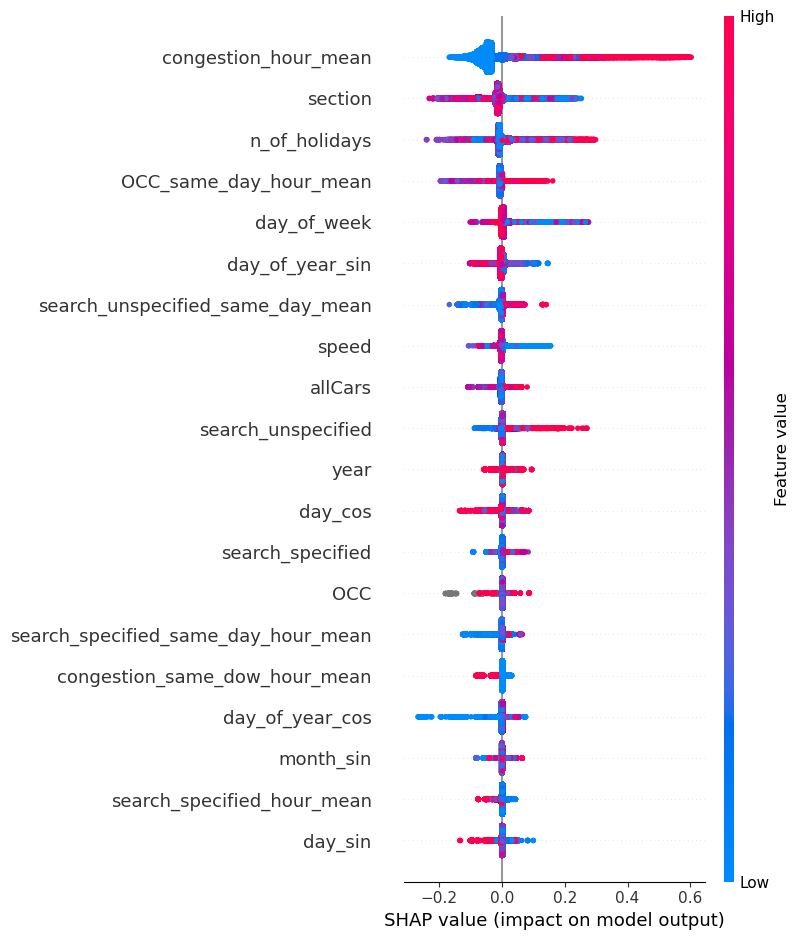

In [45]:
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(val_x.reset_index(drop=True))

shap.summary_plot(shap_values, val_x.reset_index(drop=True), show=False)
plt.show()

In [46]:
shap.plots.bar(shap_values, max_display=40)
plt.show()

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [ ]:
#df['datetime'] = pd.to_datetime(df['datetime'])
#
#folds = tss(n_splits=5)
#
#xgb_models = []
#predictions = []
#
#for fold, (train_index, val_index) in enumerate(folds.split(df)):
#    
#    train, val = df.iloc[train_index], df.iloc[val_index]
#    
#    train_y = train[target]
#    train_x = train.drop([target, *ignore_features], axis=1)
#    val_y = val[target]
#    val_x = val.drop([target, *ignore_features], axis=1)
#    
#    # sample_weightに入れる重みを計算
#    weight_train = compute_sample_weight(class_weight='balanced', y=train[target])
#
#    weight_df = pd.DataFrame()
#    weight_df['is_congestion_tomorrow'] = train['is_congestion_tomorrow']
#    weight_df['weight'] = weight_train
#    weight_df.loc[weight_df['is_congestion_tomorrow'] == 0, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 0]['weight'] * coef_0).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 0].index)
#    weight_df.loc[weight_df['is_congestion_tomorrow'] == 1, 'weight'] = (weight_df[weight_df['is_congestion_tomorrow'] == 1]['weight'] * coef_1).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 1].index)
#    weight_train = weight_df['weight']
#    
#    # optunaでパラメーター探索
#    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=123))
#    study.optimize(objective, timeout=60)
#    
#    xgb_model = XGBClassifier(**study.best_params)
#    xgb_model.fit(train_x, train_y, sample_weight=weight_train)
#    
#    xgb_models.append(xgb_model)

In [ ]:
#shap.decision_plot(explainer.expected_value, explainer.shap_values(val_x), val_x, show=False, ignore_warnings=True)
#plt.show()